### Testing QuClassi on Hardware vs Simulator (Basis)

Current quantum computers have a lot of noise, which can cause errors. In machine learning, this can lead to lower accuracy. In this test, binary classification is performed on the '3' and '6' handwritten digits on the MNIST dataset, using basis encoding. The model is trained on a simulator (because training is computationally heavy and wait times make testing on real hardware unfeasible right now). The model is tested on the hardware, and then tested on a simulator for comparison. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from math import pi,log
from qiskit import *
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
# from qiskit import IBMQ
import os
from datetime import datetime
from qiskit.circuit.library import UnitaryGate
import scipy
from scipy.stats import entropy
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from qiskit.transpiler import PassManager, InstructionDurations
import tensorflow as tf
from qiskit.circuit.library import XGate
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling

### Preprocess Data

In [2]:
from datetime import datetime
# Network saving and loading
epoch = 25
runtime_name = datetime.now().strftime("Date-%d%m%y--Hours-%H%M")
runtime_name += "-epoch-{}".format(epoch)
os.mkdir(runtime_name)
backend_sim = Aer.get_backend('qasm_simulator')


##### Data Transformation

Since MNIST contains image data, and we cannot easily feed images into a quantum computer, we conduct PCA (principal component analysis) transformation, which reduces the image into 4 dimensions (an array of 4 numbers). Then the data is scaled. Then, datasets are created for just the '3' and '6' samples, which will be classified between.

In [3]:
# Subsample to SUBSAMPLE datapoints. This is due to computational cost.
# Chance SUBSAMPLE to what best suits your computer, to make a reasonable training time.
test_images,test_labels = tf.keras.datasets.mnist.load_data()
train_images = test_images[0].reshape(60000,784)
train_labels = test_images[1]
labels = test_images[1]
train_images = train_images/255
k=4
pca = PCA(n_components=k)
pca.fit(train_images)

# Computational cost is high for 60,000 data points. Change 6000 to what your system can handle
SUBSAMPLE = 1000
pca_data = pca.transform(train_images)[:SUBSAMPLE]
train_labels = train_labels[:SUBSAMPLE]
t_pca_data = pca_data.copy()
pca_descaler = [[] for _ in range(k)]

In [4]:
# Data Transformation Section
for i in range(k):
    if pca_data[:,i].min() < 0:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] += np.abs(pca_data[:,i].min())
    else:
        pca_descaler[i].append(pca_data[:,i].min())
        pca_data[:,i] -= pca_data[:,i].min()
    pca_descaler[i].append(pca_data[:,i].max())
    pca_data[:,i] /= pca_data[:,i].max()

#CHANGE
#going to use 4 bits per component, so scale each column between 0 and 15 (4 bits)
pca_data_rot= np.round(pca_data * 3).astype(int)

valid_labels = None
valid_labels = train_labels==3
valid_labels += train_labels == 6

for col in range(pca_data.shape[1]):
    t_data_mean = pca_data[:,col].mean()
    t_data_std = pca_data[:,col].std()
    valid_upper_bound = pca_data[:,col] < t_data_mean+t_data_std
    valid_lower_bound = pca_data[:,col] > t_data_mean-t_data_std
    valid = np.logical_and(valid_upper_bound,valid_lower_bound)
    pca_data = pca_data[valid]

pca_data_rot3 = pca_data_rot[train_labels==3]
pca_data_rot6 = pca_data_rot[train_labels==6]

In [5]:
# Checkpointing code
def save_variables(var_dict, epoch, number_class):
    with open(f"{runtime_name}/Epoch-{epoch}-Variables-numbers-{number_class}", 'w') as file:
        file.write(str(var_dict))

# Ran_ang returns a random angle
def ran_ang():
    return np.random.rand() * 2 * np.pi


def single_qubit_unitary(circ_ident, qubit_index, values):
    circ_ident.ry(values[0], qubit_index)
    circ_ident.rz(values[1], qubit_index)


def dual_qubit_unitary(circ_ident, qubit_1, qubit_2, values):
    circ_ident.ryy(values[0], qubit_1, qubit_2)
    circ_ident.rzz(values[1], qubit_1, qubit_2)


def controlled_dual_qubit_unitary(circ_ident, control_qubit, act_qubit, values):
    circ_ident.cry(values[0], control_qubit, act_qubit)
    circ_ident.crz(values[1], control_qubit, act_qubit)


def traditional_learning_layer(circ_ident, num_qubits, values, style="Dual", qubit_start=1, qubit_end=5):
    if style == "Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
    elif style == "Single":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
    elif style == "Controlled-Dual":
        for qub in np.arange(qubit_start, qubit_end):
            single_qubit_unitary(circ_ident, qub, values[str(qub)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "," + str(qub + 1)])
        for qub in np.arange(qubit_start, qubit_end - 1):
            controlled_dual_qubit_unitary(circ_ident, qub, qub + 1, values[str(qub) + "--" + str(qub + 1)])


def swap_test(circ_ident, num_qubits):
    num_swap = num_qubits // 2
    for i in range(num_swap):
        circ_ident.cswap(0, i + 1, i + num_swap + 1)
    circ_ident.h(0)
    circ_ident.measure(0, 0)


def init_random_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [ran_ang(), ran_ang()]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [ran_ang(), ran_ang()]
                trainable_variables[str(i) + "--" + str(i + 1)] = [ran_ang(), ran_ang()]
    return trainable_variables


def init_gradient_variables(q, style):
    trainable_variables = {}
    if style == "Single":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
    elif style == "Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [[], []]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
    elif style == "Controlled-Dual":
        for i in np.arange(1, q + 1):
            trainable_variables[str(i)] = [0, 0]
            if i != q:
                trainable_variables[str(i) + "," + str(i + 1)] = [[], []]
                trainable_variables[str(i) + "--" + str(i + 1)] = [[], []]
    return trainable_variables


def get_probabilities_sim(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10

    transpiled_circuit = transpile(circ, backend_sim)
    job = backend_sim.run(transpiled_circuit, shots=count)
    results = job.result().get_counts()
  
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob

def get_probabilities_hardware(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10

    transpiled_circuit = transpile(circ, backend_hardware)
    job = backend_hardware.run(transpiled_circuit, shots=count)
    results = job.result().get_counts()
  
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob



# Define loss function. SWAP Test returns probability, so minmax probability is logical
def cost_function(p, yreal):
    if yreal == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)


def update_weights(init_value, lr, grad):
    while lr * grad > 2 * np.pi:
        lr /= 10
        print("Warning - Gradient taking steps that are very large. Drop learning rate")
    weight_update = lr * grad
    new_value = init_value
    if new_value - weight_update > 2 * np.pi:
        new_value = (new_value - weight_update) - 2 * np.pi
    elif new_value - weight_update < 0:
        new_value = (new_value - weight_update) + 2 * np.pi
    else:
        new_value = new_value - weight_update
    return new_value

#### Encode Data 

Amplitude encoding involves creating a unitary matrix that will transform the quantum state into a state whose amplitudes represent the data. The data is normalized, then transformed into a matrix. Through singular value decomposition, the desired unitary matrix is obtained. A custom gate is created using this matrix. This gate will be added to the training circuit.  

In [6]:
def data_loading_circuit(circ_ident, num_qubits, values, qubit_start=1, qubit_end=5):

    size = int(num_qubits / 2) #3
    stagger = size + 1
    
    #print(values[0], num_qubits)
    binary_number = bin(values[0])
    b_numbit = bin(values[0])[2:]
    formatted_binary = b_numbit.zfill(size) 
    fbin_reverse = formatted_binary[::-1]

    stagger = int((num_qubits / 2) + 1)
    for index,a in enumerate(fbin_reverse):
        if a == '1':
            circ_ident.x(index + stagger)

### Training Circuit

This adjusts parameters as indicated, then loads learning layers onto the first half of the circuit, and loads data onto the other half. It performs a swap test to test the fidelity of the states (if what was learned through the layers = what is true). Then, the changes to the parameters are reverted. 

In [7]:
# ------------------------------------------------------------------------------------
# We treat the first n qubits are the discriminators state. n is always defined as the
# integer division floor of the qubit count.
# This is due to the fact that a state will always be k qubits, therefore the
# number of total qubits must be 2k+1. 2k as we need k for the disc, and k to represent
# either the other learned quantum state, or k to represent a data point
# then +1 to perform the SWAP test. Therefore, we know that we will always end up
# with an odd number of qubits. We take the floor to solve for k. 1st k represents
# disc, 2nd k represents the "loaded" state be it gen or real data
# ------------------------------------------------------------------------------------
# Use different function calls to represent training a GENERATOR or training a DISCRIMINATOR
# ------------------------------------------------------------------------------------
def disc_real_training_circuit(training_variables, data, key=None, key_value=None, diff=False, fwd_diff=False):
    circ = QuantumCircuit(q, c)
    circ.h(0)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] += par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] -= par_shift
    traditional_learning_layer(circ, q, training_variables, style=layer_style, qubit_start=1, qubit_end=q // 2 + 1)
    data_loading_circuit(circ, q, data, qubit_start=q // 2 + 1, qubit_end=q)  
    swap_test(circ, q)
    if diff == True and fwd_diff == True:
        training_variables[key][key_value] -= par_shift
    if diff == True and fwd_diff == False:
        training_variables[key][key_value] += par_shift
    return circ

## Training

The training is done in two parts: first, a model learns to recognize 3's, then a model learns to recognize 6's. After each epoch, the accuracy is tested. The parameters are adjusted through gradient optimization.  

In [14]:
# ------------------------------------------------------------------------------------------
# THIS SECTION WE DO THE TUNING FOR WHAT WE KNOW WE WANT TO BE CHANGING!
# ------------------------------------------------------------------------------------------

q = 5  # Number of qubits = Dimensionality of data = round up to even number = num qubits
c = 1
circ = QuantumCircuit(q, c)
circ.h(0)
layer_style = "Dual"
train_var_0 = init_random_variables(q // 2, layer_style)
train_var_1 = init_random_variables(q // 2, layer_style)
train_var_2 = init_random_variables(q // 2, layer_style)

tracked_d_loss = []
tracked_d_loss1 = []
tracked_d_loss2 = []
gradients = []
learning_rate = 0.01
train_iter = 5
corr = 0
wrong = 0
loss_d_to_real = 0

losses = []
accuracies = []
entropies_all = []

print('Starting Training')
print('-' * 20)
print("train_var_0 training")
for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot3):
        for key, value in train_var_0.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities_sim(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities_sim(
                    disc_real_training_circuit(train_var_0, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_0[key][key_value] -= df * learning_rate

    # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities_sim(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities_sim(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print("-" * 20)
    save_variables(train_var_0, epoch, 3)

for epoch in range(train_iter):
    start = time.time()
    loss = [0, 0]
    par_shift = 0.5 * np.pi / ((1 + epoch) ** 0.5)
    for index, point in enumerate(pca_data_rot6):
        for key, value in train_var_1.items():
            if str(q // 2 + 1) in key:
                break
            for key_value in range(len(value)):
                forward_diff = -np.log(get_probabilities_sim(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=True)))
                backward_diff = -np.log(get_probabilities_sim(
                    disc_real_training_circuit(train_var_1, point, key, key_value, diff=True, fwd_diff=False)))
                df = 0.5 * (forward_diff - backward_diff)
                train_var_1[key][key_value] -= df * learning_rate

      # Calculate accuracy after training
    pca_data = []
    [pca_data.append(x) for x in pca_data_rot3]
    [pca_data.append(x) for x in pca_data_rot6]
    labels = []
    [labels.append(0) for _ in range(len(pca_data_rot3))]
    [labels.append(1) for _ in range(len(pca_data_rot6))]
    
    loss = 0
    correct = 0; 
    wrong = 0;
    preds = []
    reals = []
    p0_vals = []
    p1_vals = []

    for index, x in enumerate(pca_data):
        p0 = get_probabilities_sim(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
        p1 = get_probabilities_sim(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
        tp = p0 + p1
        p0 = p0 / tp
        p1 = p1 / tp
        probs = np.array([p0, p1])
        p0_vals.append(p0)
        p1_vals.append(p1)
        
        if np.argmax(probs) == 1:
            preds.append(1)
        else:
            preds.append(0)

        reals.append(labels[index])
        if np.argmax(probs) == labels[index]:
            correct += 1
        else:
            wrong += 1

    entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
    avg_ent1 = np.mean(entropies)
    entropies_all.append(avg_ent1)
    print('Entropy:', avg_ent1)

    loss = log_loss(reals, preds)
    losses.append(loss)
    print('Loss', loss)
    
    accuracy = correct / (correct + wrong)
    accuracies.append(accuracy)
    print('Accuracy', accuracy)
    
    print('Time for Epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print("-" * 20)
    save_variables(train_var_1, epoch, 6)

Starting Training
--------------------
train_var_0 training
Entropy: 0.5125835933934542
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 1 is 18.08246397972107 sec
--------------------
Entropy: 0.4390807755518395
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 2 is 18.114596843719482 sec
--------------------
Entropy: 0.40658218286713366
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 3 is 17.94778800010681 sec
--------------------
Entropy: 0.44069827527493893
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 4 is 18.0724778175354 sec
--------------------
Entropy: 0.5141000358116209
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 5 is 18.195594787597656 sec
--------------------
Entropy: 0.9189909841883038
Loss 15.034251146262765
Accuracy 0.5828877005347594
Time for Epoch 1 is 18.34888505935669 sec
--------------------
Entropy: 0.8510831483053709
Loss 15.226997955830239
Accuracy 0.5775401069518716

Although through training the model was able to obtain about 85% accuracy, when tested on the hardware the accuracy was close to 50% due to noise. 

### Training Metrics

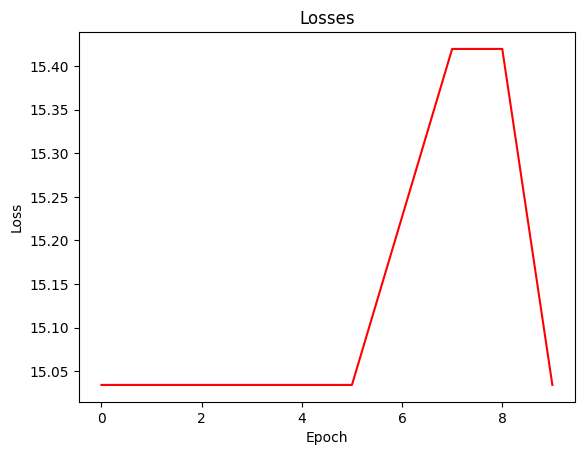

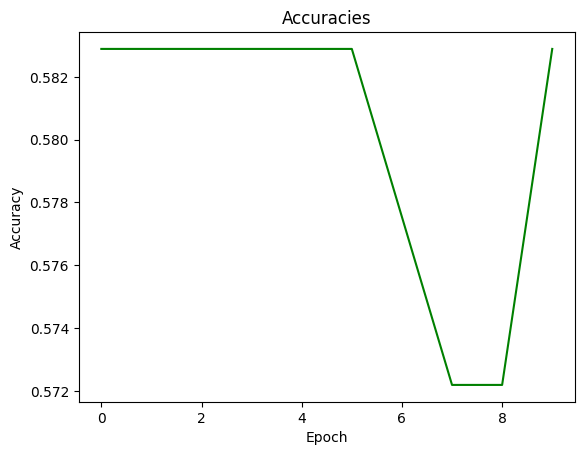

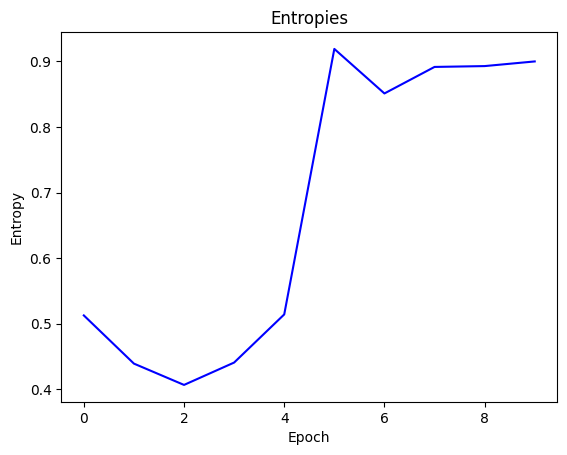

In [16]:
plt.plot(losses, label='Losses', color='red')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies, label='Accuracies', color='green')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(entropies_all, label='Entropies', color='blue')
plt.title('Entropies')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.show()

### testing on Simulator

In [17]:
#CHANGE PCA_DATA_ROT VARS HERE
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]
correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

In [18]:
for index, x in enumerate(pca_data):
    p0 = get_probabilities_sim(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities_sim(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Ones predicted 42 Zeros predicted 145
Accuracy 0.5828877005347594
Average entropy 0.8981933863739886


# hardware with error mitgation

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService

#### service = ######
backend_hardware = service.backend('ibm_torino')

In [35]:
p0_jobids = []
p1_jobids = []

In [36]:
pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

submit jobs to get probabilities (run asap)

In [21]:
def submit_job(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10 

    #prepare the circuit for the backend
    transpiled_circuit = transpile(circ, backend_hardware, scheduling_method="alap")

    #add dynamical decoupling
    dd_sequence = [XGate(), XGate()]
    durations = InstructionDurations.from_backend(backend_hardware)
    pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence)])
    circ_dd = pm.run(transpiled_circuit)

    #run the job with dynamical decoupling
    job = backend_hardware.run(circ_dd, shots=count)
    return job.job_id()

In [22]:
for index, x in enumerate(pca_data):
    p0_jobids.append(submit_job(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False)))
    p1_jobids.append(submit_job(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False)))

<font color ='red'> when jobs finish running, run this to get metrics

In [37]:
p0_jobids = ['ctm17a56g3rg00874q70', 
 'ctm17axx7b5g00807mbg', 
 'ctm17bx4gjh0008p7cpg', 
 'ctm17cn4gzyg008z6tw0', 
 'ctm17dnsj17g0081r090', 
 'ctm17e5907y0008w0ywg', 
 'ctm17en4gjh0008p7cqg', 
 'ctm17fd6g3rg00874q8g', 
 'ctm17fx4gzyg008z6txg', 
 'ctm17gp6g3rg00874q9g', 
 'ctm17h64gzyg008z6ty0', 
 'ctm17hp4gjh0008p7cr0', 
 'ctm17je6g3rg00874qa0', 
 'ctm17jy6g3rg00874qag', 
 'ctm17kpsj17g0081r0bg', 
 'ctm17m64gjh0008p7cs0', 
 'ctm17mp4gzyg008z6tzg', 
 'ctm17ne907y0008w0yxg', 
 'ctm17nysj17g0081r0cg', 
 'ctm17ppsj17g0081r0d0', 
 'ctm17qex7b5g00807mj0', 
 'ctm17r7x7b5g00807mjg', 
 'ctm17rqsj17g0081r0e0', 
 'ctm17sf907y0008w0yz0', 
 'ctm17t74gzyg008z6v20', 
 'ctm17tq4gjh0008p7ctg', 
 'ctm17vf4gjh0008p7cv0', 
 'ctm17vz4gjh0008p7cw0', 
 'ctm17wqsj17g0081r0fg', 
 'ctm17x7sj17g0081r0gg', 
 'ctm17xz6g3rg00874qfg', 
 'ctm17yf907y0008w0z2g', 
 'ctm17z74gjh0008p7cxg', 
 'ctm17zq4gjh0008p7cy0', 
 'ctm1800sj17g0081r0j0', 
 'ctm180r6g3rg00874qh0', 
 'ctm18186g3rg00874qhg', 
 'ctm1820sj17g0081r0k0', 
 'ctm182g4gzyg008z6v50', 
 'ctm18384gjh0008p7cz0', 
 'ctm183rsj17g0081r0kg', 
 'ctm18486g3rg00874qj0', 
 'ctm1850sj17g0081r0m0', 
 'ctm185gsj17g0081r0mg', 
 'ctm1868907y0008w0z50', 
 'ctm186rx7b5g00807mt0', 
 'ctm187gsj17g0081r0n0', 
 'ctm18814gjh0008p7d1g', 
 'ctm188sx7b5g00807mx0', 
 'ctm1899x7b5g00807mxg', 
 'ctm189sx7b5g00807myg', 
 'ctm18ah6g3rg00874qng', 
 'ctm18b1x7b5g00807mz0', 
 'ctm18bh907y0008w0z7g', 
 'ctm18c96g3rg00874qqg', 
 'ctm18d16g3rg00874qr0', 
 'ctm18dsx7b5g00807n0g', 
 'ctm18e94gjh0008p7d40', 
 'ctm18f1sj17g0081r0q0', 
 'ctm18fsx7b5g00807n20', 
 'ctm18ga6g3rg00874qv0', 
 'ctm18gt4gjh0008p7d50', 
 'ctm18hj4gzyg008z6v9g', 
 'ctm18j2x7b5g00807n3g', 
 'ctm18jtsj17g0081r0s0', 
 'ctm18kasj17g0081r0sg', 
 'ctm18kt6g3rg00874qx0', 
 'ctm18mj4gjh0008p7d6g', 
 'ctm18n26g3rg00874qy0', 
 'ctm18ntsj17g0081r0vg', 
 'ctm18pa6g3rg00874r00', 
 'ctm18pt4gjh0008p7d7g', 
 'ctm18qjx7b5g00807n80', 
 'ctm18r36g3rg00874r10', 
 'ctm18rk907y0008w0zdg', 
 'ctm18sb907y0008w0ze0', 
 'ctm18svx7b5g00807n8g', 
 'ctm18tkx7b5g00807n90', 
 'ctm18v3x7b5g00807n9g', 
 'ctm18vv4gjh0008p7dag', 
 'ctm18wbx7b5g00807na0', 
 'ctm18x34gjh0008p7db0', 
 'ctm18xk6g3rg00874r4g', 
 'ctm18ybx7b5g00807nag', 
 'ctm18yvsj17g0081r0xg', 
 'ctm18zk6g3rg00874r50', 
 'ctm1904sj17g0081r0y0', 
 'ctm190m6g3rg00874r60', 
 'ctm191cx7b5g00807nb0', 
 'ctm191wsj17g0081r0zg', 
 'ctm192m6g3rg00874r70', 
 'ctm19344gjh0008p7dd0', 
 'ctm193wx7b5g00807ncg', 
 'ctm194m6g3rg00874r80', 
 'ctm19544gzyg008z6vf0', 
 'ctm195msj17g0081r110', 
 'ctm196c4gjh0008p7de0', 
 'ctm196w4gjh0008p7deg', 
 'ctm197m4gjh0008p7df0', 
 'ctm1985x7b5g00807ne0', 
 'ctm198x6g3rg00874ra0', 
 'ctm199d6g3rg00874rb0', 
 'ctm199xsj17g0081r12g', 
 'ctm19an4gzyg008z6vgg', 
 'ctm19bd907y0008w0zj0', 
 'ctm19bxx7b5g00807nfg', 
 'ctm19cn6g3rg00874rdg', 
 'ctm19ddsj17g0081r13g', 
 'ctm19dx907y0008w0zjg', 
 'ctm19en6g3rg00874reg', 
 'ctm19f5sj17g0081r140', 
 'ctm19fxsj17g0081r14g', 
 'ctm19ge6g3rg00874rf0', 
 'ctm19h6907y0008w0zkg', 
 'ctm19hp4gjh0008p7dhg', 
 'ctm19je4gjh0008p7djg', 
 'ctm19jy907y0008w0zm0', 
 'ctm19kpsj17g0081r150', 
 'ctm19m66g3rg00874rh0', 
 'ctm19mp6g3rg00874rhg', 
 'ctm19ne4gjh0008p7dkg', 
 'ctm19ny4gjh0008p7dmg', 
 'ctm19pp6g3rg00874rj0', 
 'ctm19qex7b5g00807njg', 
 'ctm19qy4gzyg008z6vkg', 
 'ctm19rfx7b5g00807nk0', 
 'ctm19s7sj17g0081r160', 
 'ctm19sqsj17g0081r16g', 
 'ctm19t7x7b5g00807nn0', 
 'ctm19tz4gzyg008z6vmg', 
 'ctm19vfx7b5g00807nng', 
 'ctm19w74gjh0008p7dqg', 
 'ctm19wzsj17g0081r17g', 
 'ctm19xf907y0008w0zqg', 
 'ctm19y76g3rg00874rkg', 
 'ctm19yqsj17g0081r180', 
 'ctm19zqsj17g0081r18g', 
 'ctm1a004gzyg008z6vqg', 
 'ctm1a0r6g3rg00874rn0', 
 'ctm1a1g4gjh0008p7dt0', 
 'ctm1a204gzyg008z6vrg', 
 'ctm1a2r4gjh0008p7dtg', 
 'ctm1a386g3rg00874rpg', 
 'ctm1a3r907y0008w0ztg', 
 'ctm1a4gx7b5g00807nr0', 
 'ctm1a504gzyg008z6vs0', 
 'ctm1a5rsj17g0081r1ag', 
 'ctm1a684gjh0008p7dwg', 
 'ctm1a704gjh0008p7dy0', 
 'ctm1a7r4gzyg008z6vt0', 
 'ctm1a8h6g3rg00874rt0', 
 'ctm1a9h907y0008w0zwg', 
 'ctm1aa14gjh0008p7dz0', 
 'ctm1aah907y0008w0zy0', 
 'ctm1ab94gzyg008z6vvg', 
 'ctm1ac1x7b5g00807nt0', 
 'ctm1acs4gjh0008p7dzg', 
 'ctm1ad96g3rg00874rvg', 
 'ctm1ae1sj17g0081r1cg', 
 'ctm1aesx7b5g00807ntg', 
 'ctm1af94gzyg008z6vx0', 
 'ctm1ag26g3rg00874rw0', 
 'ctm1agj907y0008w0zzg', 
 'ctm1aha907y0008w1000', 
 'ctm1aht4gjh0008p7e0g', 
 'ctm1ajj907y0008w100g', 
 'ctm1ak26g3rg00874rwg', 
 'ctm1aktsj17g0081r1eg', 
 'ctm1ama4gjh0008p7e10', 
 'ctm1an2sj17g0081r1f0', 
 'ctm1antx7b5g00807nw0', 
 'ctm1apa907y0008w102g', 
 'ctm1aq24gjh0008p7e2g', 
 'ctm1aqj4gzyg008z6w0g', 
 'ctm1arb4gjh0008p7e3g', 
 'ctm1arv6g3rg00874ry0', 
 'ctm1ask6g3rg00874ryg', 
 'ctm1atbsj17g0081r1g0', 
 'ctm1av34gjh0008p7e4g', 
 'ctm1avkx7b5g00807nz0', 
 'ctm1awk4gjh0008p7e50', 
 'ctm1ax34gjh0008p7e5g', 
 'ctm1axvx7b5g00807nzg', 
 'ctm1ayb6g3rg00874s10', 
 'ctm1az3sj17g0081r1gg', 
 'ctm1azkx7b5g00807p2g', 
 'ctm1b0csj17g0081r1hg'] 

In [38]:
p1_jobids = ['ctm17ad907y0008w0yvg', 
 'ctm17b5x7b5g00807mc0', 
 'ctm17cd6g3rg00874q80', 
 'ctm17cx4gjh0008p7cq0', 
 'ctm17dx907y0008w0yw0', 
 'ctm17edx7b5g00807mdg', 
 'ctm17f5x7b5g00807me0', 
 'ctm17fnx7b5g00807meg', 
 'ctm17ge6g3rg00874q90', 
 'ctm17gyx7b5g00807mf0', 
 'ctm17hex7b5g00807mfg', 
 'ctm17j64gzyg008z6tyg', 
 'ctm17jpx7b5g00807mg0', 
 'ctm17k64gjh0008p7crg', 
 'ctm17ky6g3rg00874qb0', 
 'ctm17mesj17g0081r0c0', 
 'ctm17n6x7b5g00807mgg', 
 'ctm17npx7b5g00807mh0', 
 'ctm17pe6g3rg00874qc0', 
 'ctm17q6x7b5g00807mhg', 
 'ctm17qpsj17g0081r0dg', 
 'ctm17rf6g3rg00874qe0', 
 'ctm17s7x7b5g00807mkg', 
 'ctm17sqx7b5g00807mmg', 
 'ctm17tfx7b5g00807mng', 
 'ctm17tzsj17g0081r0eg', 
 'ctm17vq4gjh0008p7cvg', 
 'ctm17w74gjh0008p7cwg', 
 'ctm17wz4gzyg008z6v2g', 
 'ctm17xfsj17g0081r0hg', 
 'ctm17y76g3rg00874qg0', 
 'ctm17yq4gzyg008z6v30', 
 'ctm17zf4gzyg008z6v3g', 
 'ctm17zzx7b5g00807mrg', 
 'ctm180gx7b5g00807ms0', 
 'ctm18104gzyg008z6v4g', 
 'ctm181r907y0008w0z40', 
 'ctm1828907y0008w0z4g', 
 'ctm182r4gjh0008p7cyg', 
 'ctm183g4gzyg008z6v5g', 
 'ctm18404gzyg008z6v60', 
 'ctm184r4gzyg008z6v6g', 
 'ctm18584gjh0008p7d0g', 
 'ctm185r4gzyg008z6v70', 
 'ctm186g4gzyg008z6v7g', 
 'ctm18704gjh0008p7d10', 
 'ctm187r907y0008w0z5g', 
 'ctm18896g3rg00874qkg', 
 'ctm1891907y0008w0z6g', 
 'ctm189h4gjh0008p7d2g', 
 'ctm18a16g3rg00874qn0', 
 'ctm18as4gjh0008p7d30', 
 'ctm18b9907y0008w0z70', 
 'ctm18c16g3rg00874qq0', 
 'ctm18ch4gjh0008p7d3g', 
 'ctm18d9sj17g0081r0p0', 
 'ctm18e14gzyg008z6v90', 
 'ctm18es907y0008w0z90', 
 'ctm18f94gjh0008p7d4g', 
 'ctm18g26g3rg00874qtg', 
 'ctm18gjsj17g0081r0qg', 
 'ctm18hax7b5g00807n30', 
 'ctm18ht4gjh0008p7d5g', 
 'ctm18jj4gzyg008z6vag', 
 'ctm18k2x7b5g00807n4g', 
 'ctm18kj6g3rg00874qwg', 
 'ctm18ma4gzyg008z6vbg', 
 'ctm18mt6g3rg00874qxg', 
 'ctm18nax7b5g00807n6g', 
 'ctm18p2x7b5g00807n70', 
 'ctm18pj907y0008w0zag', 
 'ctm18qa6g3rg00874r0g', 
 'ctm18qt907y0008w0zcg', 
 'ctm18rbsj17g0081r0w0', 
 'ctm18s34gjh0008p7d80', 
 'ctm18sk907y0008w0zeg', 
 'ctm18tb4gjh0008p7d8g', 
 'ctm18tv4gjh0008p7d90', 
 'ctm18vk6g3rg00874r30', 
 'ctm18w3sj17g0081r0wg', 
 'ctm18wvsj17g0081r0x0', 
 'ctm18xb4gjh0008p7dbg', 
 'ctm18xv907y0008w0zfg', 
 'ctm18yk4gzyg008z6vdg', 
 'ctm18zb4gjh0008p7dc0', 
 'ctm18zv4gjh0008p7dcg', 
 'ctm190csj17g0081r0yg', 
 'ctm1914sj17g0081r0z0', 
 'ctm191m907y0008w0zg0', 
 'ctm19244gzyg008z6ve0', 
 'ctm192wx7b5g00807nc0', 
 'ctm193m907y0008w0zh0', 
 'ctm1944sj17g0081r100', 
 'ctm194w4gzyg008z6veg', 
 'ctm195csj17g0081r10g', 
 'ctm195wx7b5g00807nd0', 
 'ctm196msj17g0081r11g', 
 'ctm19746g3rg00874r8g', 
 'ctm197w4gzyg008z6vfg', 
 'ctm198nx7b5g00807neg', 
 'ctm19956g3rg00874rag', 
 'ctm199nx7b5g00807nf0', 
 'ctm19ad6g3rg00874rcg', 
 'ctm19ax6g3rg00874rd0', 
 'ctm19bn4gjh0008p7dg0', 
 'ctm19cd4gzyg008z6vh0', 
 'ctm19cxx7b5g00807ng0', 
 'ctm19dn6g3rg00874re0', 
 'ctm19e54gjh0008p7dgg', 
 'ctm19ex4gjh0008p7dh0', 
 'ctm19fd4gzyg008z6vhg', 
 'ctm19g6907y0008w0zk0', 
 'ctm19gy6g3rg00874rfg', 
 'ctm19he6g3rg00874rg0', 
 'ctm19hy4gjh0008p7dj0', 
 'ctm19jp4gzyg008z6vjg', 
 'ctm19k66g3rg00874rgg', 
 'ctm19ky907y0008w0zmg', 
 'ctm19mesj17g0081r15g', 
 'ctm19n6907y0008w0zn0', 
 'ctm19np4gjh0008p7dm0', 
 'ctm19p6x7b5g00807nj0', 
 'ctm19py4gzyg008z6vk0', 
 'ctm19qp6g3rg00874rjg', 
 'ctm19r74gjh0008p7dn0', 
 'ctm19rzx7b5g00807nkg', 
 'ctm19sfx7b5g00807nm0', 
 'ctm19szx7b5g00807nmg', 
 'ctm19tf4gjh0008p7dng', 
 'ctm19v74gjh0008p7dp0', 
 'ctm19vzsj17g0081r170', 
 'ctm19wf4gzyg008z6vng', 
 'ctm19x74gjh0008p7dr0', 
 'ctm19xz4gjh0008p7drg', 
 'ctm19yf6g3rg00874rm0', 
 'ctm19z74gjh0008p7ds0', 
 'ctm19zz907y0008w0zr0', 
 'ctm1a084gzyg008z6vr0', 
 'ctm1a10x7b5g00807npg', 
 'ctm1a1r6g3rg00874rng', 
 'ctm1a2g6g3rg00874rp0', 
 'ctm1a30sj17g0081r190', 
 'ctm1a3g907y0008w0zt0', 
 'ctm1a48x7b5g00807nq0', 
 'ctm1a4r907y0008w0zv0', 
 'ctm1a584gjh0008p7dv0', 
 'ctm1a604gjh0008p7dw0', 
 'ctm1a6r4gjh0008p7dxg', 
 'ctm1a786g3rg00874rqg', 
 'ctm1a89x7b5g00807nrg', 
 'ctm1a8s4gjh0008p7dyg', 
 'ctm1a9s4gzyg008z6vv0', 
 'ctm1aa9907y0008w0zxg', 
 'ctm1ab1sj17g0081r1bg', 
 'ctm1abh4gzyg008z6vw0', 
 'ctm1ac94gzyg008z6vwg', 
 'ctm1ad16g3rg00874rv0', 
 'ctm1adssj17g0081r1c0', 
 'ctm1ae9sj17g0081r1d0', 
 'ctm1af1907y0008w0zz0', 
 'ctm1afs4gzyg008z6vxg', 
 'ctm1aga4gjh0008p7e00', 
 'ctm1agt4gzyg008z6vy0', 
 'ctm1ahj4gzyg008z6vyg', 
 'ctm1aj2sj17g0081r1dg', 
 'ctm1ajtsj17g0081r1e0', 
 'ctm1akjx7b5g00807nv0', 
 'ctm1am2x7b5g00807nvg', 
 'ctm1amt907y0008w1010', 
 'ctm1ana907y0008w101g', 
 'ctm1ap2x7b5g00807nwg', 
 'ctm1apj4gjh0008p7e20', 
 'ctm1aqa6g3rg00874rxg', 
 'ctm1ar3x7b5g00807nx0', 
 'ctm1arkx7b5g00807nxg', 
 'ctm1as3907y0008w1030', 
 'ctm1asv4gjh0008p7e40', 
 'ctm1atk4gzyg008z6w20', 
 'ctm1avbx7b5g00807nyg', 
 'ctm1avv6g3rg00874rzg', 
 'ctm1awv6g3rg00874s0g', 
 'ctm1axb907y0008w103g', 
 'ctm1ay3x7b5g00807p00', 
 'ctm1ayk4gjh0008p7e60', 
 'ctm1azbx7b5g00807p20', 
 'ctm1azvsj17g0081r1h0', 
 'ctm1b0msj17g0081r1j0'] 

In [40]:
def get_probs(jobid):
    job = service.job(jobid)
    results = job.result().get_counts()
  
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob

In [42]:
for index, x in enumerate(pca_data):
    try:
        p0 = get_probs(p0_jobids[index])
        try:
            p1 = get_probs(p1_jobids[index])
        except Exception as e:
            failed_jobs_p1.append(p1_jobids[index])
            continue
    except Exception as e:
        failed_jobs_p0.append(p0_jobids[index])
        try:
            p1 = get_probs(p1_jobids[index])
        except Exception as e:
            failed_jobs_p1.append(p1_jobids[index])
        continue
        
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

In [43]:
entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Ones predicted 56 Zeros predicted 131
Accuracy 0.5721925133689839
Average entropy 0.8827334773057387


### <font color="red"> FAKE HARDWARE (dynamical decoupling)

In [26]:
backend_dupe = service.backend('ibm_torino')
from qiskit_aer import AerSimulator
backend_fake = AerSimulator.from_backend(backend_dupe)

In [27]:
p0_jobids = []
p1_jobids = []

pca_data = []
[pca_data.append(x) for x in pca_data_rot3]
[pca_data.append(x) for x in pca_data_rot6]
labels = []
[labels.append(0) for _ in range(len(pca_data_rot3))]
[labels.append(1) for _ in range(len(pca_data_rot6))]

correct = 0
wrong = 0
ones = []
zeros = []
layer_style = 'Dual'

ones_predicted = 0
zeros_predicted = 0

p0_vals = []
p1_vals = []

In [28]:
def get_probabilities_fake(circ, count=10000, inducing=False):
    if inducing == True:
        count *= 10 

    #prepare the circuit for the backend
    transpiled_circuit = transpile(circ, backend_fake, scheduling_method="alap")

    #add dynamical decoupling
    dd_sequence = [XGate(), XGate()]
    durations = InstructionDurations.from_backend(backend_dupe)
    pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence)])
    circ_dd = pm.run(transpiled_circuit)

    #run the job with dynamical decoupling
    job = backend_fake.run(circ_dd, shots=count)
    results = job.result().get_counts()
  
    try:
        prob = results['0'] / (results['1'] + results['0'])
        prob = (prob - 0.5)
        if prob <= 0:
            prob = 1e-16
        else:
            prob = prob * 2
    except:
        prob = 1
    return prob

In [30]:
for index, x in enumerate(pca_data):
    p0 = get_probabilities_fake(disc_real_training_circuit(train_var_0, x, None, None, diff=False, fwd_diff=False))
    p1 = get_probabilities_fake(disc_real_training_circuit(train_var_1, x, None, None, diff=False, fwd_diff=False))
    tp = p0 + p1
    p0 = p0 / tp
    p1 = p1 / tp
    probs = np.array([p0, p1])

    if np.argmax(probs) == labels[index]:
        correct += 1
    else:
        wrong += 1

    if np.argmax(probs) == 1:
        ones_predicted += 1
    else:
        zeros_predicted += 1

    p0_vals.append(p0)
    p1_vals.append(p1)

entropies = entropy([np.array(p0_vals), np.array(p1_vals)], base = 2, axis = 0)
avg_ent = np.mean(entropies)

print("Ones predicted", ones_predicted, "Zeros predicted", zeros_predicted)
print(f"Accuracy {correct / (correct + wrong)}")
print("Average entropy", avg_ent)

Ones predicted 45 Zeros predicted 155
Accuracy 0.595
Average entropy 0.9058950541436381
